In [34]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_sched
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt

In [35]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [36]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [37]:
"""
Do grzyb/nie grzyb - transform_raw_1
Do klasyfikacji - transform_raw_2 (zachowuje więcej szczegółów)
"""
transform_raw_1 = transforms.Compose([
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
)

transform_raw_2 = transforms.Compose([
    transforms.Resize([250, 250]),
    transforms.ToTensor(),
     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
)

In [38]:
dataset = torchvision.datasets.ImageFolder("DS_MASHROOM_OR_NOT", transform=transform_raw_1)
len(dataset)

11922

In [39]:
dataset.class_to_idx

{'Mashroom': 0, 'unlabeled_images': 1}

In [40]:
seed = 123
torch.manual_seed(seed)

In [41]:
train_size = 10500
val_size = len(dataset) - train_size

train_ds, val_ds = data.random_split(dataset, [train_size, val_size])

In [42]:
batch_size = 500

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, pin_memory=True, num_workers=0)

In [43]:
class RestPercepton_block(nn.Module):
    """
    Base class for percepton block with residual connection (no pre-activation and BN before conv)

    in_channels - num. channles into block
    out_channels - num. concatenated channles out from block
    conv_size_in - list of num. of channels into 3 and 5 conv (respectively) [conv 1x1 in is always size of in_channels]
    conv_size_out - list of num. of channels going out from 1,3,5 conv (-||-)
    stride, padding - list with stride and padding values for 1, 3, 5 conv respectively
    change_depth_pool - change depth for pooling. By default "False"(no change), if used must be int (out depth from pool section)
    """


    #TODO add batch normalization and activation functions after conv
    def __init__(self, in_channels, out_channels,
                conv_size_in:list, conv_size_out:list,
                stride:list=[1,1,1], padding:list=[0, 1, 2],
                change_depth_pool=False):

        # checking if dim are correct
        if(change_depth_pool):
            if(out_channels != sum(conv_size_out) + change_depth_pool):
                raise ValueError(
                    f'Sum of out channels of the block must be equal to sum of out channels of convs inside the block (out={out_channels};conv{sum(conv_size_out)+change_depth_pool} )'
                )
        elif(not change_depth_pool):
            if(out_channels != sum(conv_size_out) + in_channels):
                raise ValueError(
                    f'Sum of out channels of the block must be equal to sum of out channels of convs inside the block (out={out_channels};conv{sum(conv_size_out)+change_depth_pool} )'
                )

        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels


        # conv 1x1
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, conv_size_out[0], kernel_size=1, stride=stride[0], padding=padding[0]),
            nn.BatchNorm2d(conv_size_out[0]),
            nn.ReLU()
        )

        # conv 3x3
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels, conv_size_in[0], kernel_size=1, padding=0, stride=1), # change depth so it matches 3x3 conv in size
            nn.Conv2d(conv_size_in[0], conv_size_out[1], kernel_size=3, stride=stride[1], padding=padding[1]),
            nn.BatchNorm2d(conv_size_out[1]),
            nn.ReLU()
        )

       # conv 5x5
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels, conv_size_in[1], kernel_size=1, padding=0, stride=1),
            nn.Conv2d(conv_size_in[1], conv_size_out[2], kernel_size=5, stride=stride[2], padding=padding[2]),
            nn.BatchNorm2d(conv_size_out[2]),
            nn.ReLU()
        )

        # max pool 3x3
        if(change_depth_pool):
            self.pool = nn.Sequential(
                nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                nn.Conv2d(in_channels, change_depth_pool, kernel_size=1, padding=0, stride=1),
                nn.BatchNorm2d(change_depth_pool),
                nn.ReLU()
            )

        else:
            self.pool = nn.Sequential(
                nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(self.in_channels),
                nn.ReLU()
            )

        # changer depth of rest connection
        if(in_channels != out_channels):
            self.RestConv = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=1)

    def forward(self, x):

        conv1 = self.conv1(x)
        conv3 = self.conv3(x)
        conv5 = self.conv5(x)
        pool = self.pool(x)

        if(self.in_channels != self.out_channels):

            residual = self.RestConv(x)
        else:
            residual = x


        return(torch.cat([conv1, conv3, conv5, pool], dim=1) + residual)

In [44]:
class ImageClassifierNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()

    def train_step(self, input, labels):
        input = input.to(device=device)
        labels = labels.to(device=device)

        preds = self.forward(input)
        labels = labels.unsqueeze(1).float() # pred are 2-dim, so we either have to squeze preds dim1 or unsqueeze labels on dim1
        loss = self.loss(preds, labels)

        return loss

    def val_step(self, input, labels):

        input = input.to(device=device)
        labels = labels.to(device=device)

        preds = self.forward(input)
        labels = labels.unsqueeze(1).float()
        loss = self.loss(preds, labels)
        accuracy = self._accuracy(preds, labels)

        return {"loss":loss.detach(), "accuracy":accuracy}


    def val_epoch_end(self, preformance_measurement_data):

        accuracy = [x["accuracy"] for x in preformance_measurement_data]
        avg_accuracy = np.mean(accuracy)

        loss = [x["loss"].cpu().numpy() for x in preformance_measurement_data]
        avg_loss = np.mean(loss)

        return avg_loss, avg_accuracy


    def _accuracy(self, preds, labels):

        probabilities = torch.sigmoid(preds)

        predicted_labels = (probabilities > .5).float()

        correct = (predicted_labels == labels).float()
        accuracy = correct.sum() / len(preds)

        return accuracy.item()

In [45]:
class RestGoogleNet_Clasificator(ImageClassifierNetwork):
    """
    Input - in_channels x 96x96
    """
    def __init__(self, in_channels):
        super().__init__()


        self.Intercepton1 = RestPercepton_block(in_channels=32, out_channels=144, conv_size_in=[32,32], conv_size_out=[16, 48, 48],change_depth_pool=False)
        self.Intercepton2 = RestPercepton_block(in_channels=144, out_channels=208, conv_size_in=[64,64], conv_size_out=[24, 72, 64],change_depth_pool= 48)
        self.Intercepton3 = RestPercepton_block(in_channels=208, out_channels=232, conv_size_in=[96,96], conv_size_out=[32, 96, 72],change_depth_pool=32)
        self.Intercepton4 = RestPercepton_block(in_channels=232, out_channels=288, conv_size_in=[128,128], conv_size_out=[48, 128, 96],change_depth_pool=16)

        self.Conv1 = nn.Conv2d(in_channels, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.Conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)

        self.MaxPool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.AvgPool_6x6 = nn.AvgPool2d(kernel_size=8, stride=1)

        self.Dropout = nn.Dropout(0.5)
        self.Linear = nn.Linear(288, 1)

        self.BN1 = nn.BatchNorm2d(16)
        self.BN2 = nn.BatchNorm2d(32)
        self.BN3 = nn.BatchNorm2d(264)

        self.activation = nn.ReLU()


    def forward(self, x):

        x = self.Conv1(x)
        x = self.BN1(x)
        x = self.activation(x)
        x = self.MaxPool_2x2(x) #64x64

        x = self.Conv2(x)
        x = self.BN2(x)
        x = self.activation(x)
        x = self.MaxPool_2x2(x) #32x32

        x = self.Intercepton1(x)
        x = self.MaxPool_2x2(x) # 16x16

        x = self.Intercepton2(x)
        x = self.Intercepton3(x)
        x = self.MaxPool_2x2(x) # 232x8x8

        x = self.Intercepton4(x)
        x = self.AvgPool_6x6(x) # 288x1x1

        x = x.view(x.size(0), -1)

        x = self.Dropout(x)
        x = self.Linear(x)

        return x

In [46]:
model = RestGoogleNet_Clasificator(in_channels=3)
model.to(device)
# model.load_state_dict(torch.load("5_epch_googleNet_BINARY_V2_128X128.pt"))


RestGoogleNet_Clasificator(
  (loss): BCEWithLogitsLoss()
  (Intercepton1): RestPercepton_block(
    (conv1): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv5): Sequential(
      (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (pool): Sequential(
      (0): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (1): BatchNorm2d(32, eps=1e-05

In [47]:
params_sum = 0
for params in model.parameters():
    params_sum+=params.view(-1).size(0)
params_sum

1234033

In [48]:
epoch = 10

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=.95)

In [49]:
def eval(val_loader, model):
        history = []
        for input, label in val_loader:
            history += [model.val_step(input, label)]

        loss_val, acc_val = model.val_epoch_end(history)

        return loss_val, acc_val

In [50]:
torch.manual_seed(seed=torch.initial_seed())

transform = transforms.RandomChoice(
    [
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(degrees=(20, 60)),
    transforms.RandomPerspective(distortion_scale=.35),
    ]
)

In [51]:
def train(train_dataloader, epoch):
    model.train(mode=True)

    epoch_loss_T = []
    batch_loss_T = []
    epoch_loss_V = []
    epoch_acc_V = []


    for ep in range(epoch):

        for input, label in train_dataloader:

            transformed_input = transform(input)
            loss = model.train_step(transformed_input, label)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            lr_scheduler.step()

            batch_loss_T += [loss.item()]

        epoch_loss_T += [np.mean(batch_loss_T)]
        batch_loss_T = []

        loss_val, acc_val = eval(val_loader, model)
        epoch_loss_V += [loss_val]
        epoch_acc_V += [acc_val]

        print(f'Epoch {ep+1}; TLoss: {epoch_loss_T[ep]}; Vloss: {loss_val}; Acc: {acc_val}')
        torch.save(model.state_dict(), f=f'models_BIN/model_epoch{ep}.pt')


    model.eval()
    return epoch_loss_T, epoch_loss_V, epoch_acc_V

In [52]:
loss_T, loss_V, acc_V = train(train_loader, epoch)

Epoch 1; TLoss: 0.350387814499083; Vloss: 0.18178020417690277; Acc: 0.9343539079030355
Epoch 2; TLoss: 0.1519829478292238; Vloss: 0.11723574250936508; Acc: 0.9564992785453796
Epoch 3; TLoss: 0.13003220409154892; Vloss: 0.10971952229738235; Acc: 0.9637820323308309
Epoch 4; TLoss: 0.1125476849930627; Vloss: 0.10589275509119034; Acc: 0.9639052351315817
Epoch 5; TLoss: 0.1157221645116806; Vloss: 0.10530873388051987; Acc: 0.9645719130833944
Epoch 6; TLoss: 0.10993988705532891; Vloss: 0.10462319850921631; Acc: 0.9631153543790182
Epoch 7; TLoss: 0.10337837430692855; Vloss: 0.10442725569009781; Acc: 0.9652385711669922
Epoch 8; TLoss: 0.1075730337983086; Vloss: 0.10241948813199997; Acc: 0.9652385711669922
Epoch 9; TLoss: 0.11402022874071485; Vloss: 0.10101693868637085; Acc: 0.9660284916559855
Epoch 10; TLoss: 0.11339149304798671; Vloss: 0.10340187698602676; Acc: 0.9636588096618652


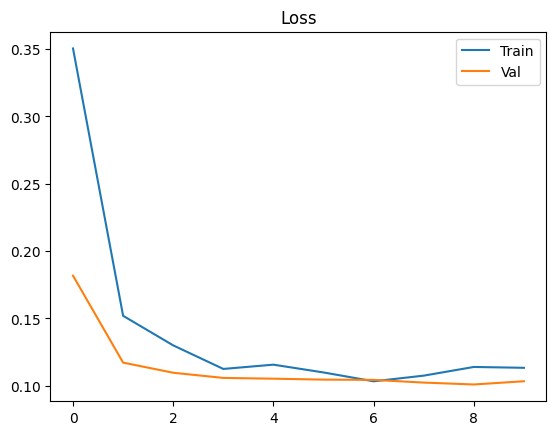

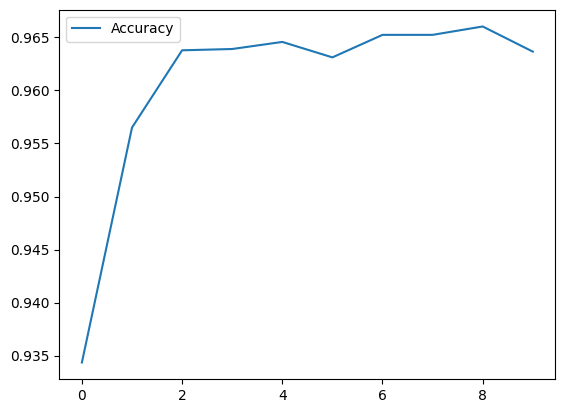

In [53]:
def plot_results(loss_T, loss_V, acc_V):

    # fig = plt.figure
    plt.plot(loss_T, label="Train")
    plt.plot(loss_V, label="Val")
    plt.title("Loss")
    plt.legend()
    plt.show()

    # fig2 = plt.figure
    plt.plot(acc_V, label="Accuracy")
    plt.legend()
    plt.show()

plot_results(loss_T, loss_V, acc_V)

### Evaluation on test set 

In [54]:
batch_size = 200
test_dataset = torchvision.datasets.ImageFolder(root="Test_MASHROOM_OR_NOT", transform=transform_raw_1)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, num_workers=0, pin_memory=True)

In [55]:
def eval_test(test_loader, model):

    accuracy = []

    for input, label in test_loader:
        input = input.to(device)
        label = label.to(device)

        preds = model.forward(input)

        probabilities = torch.sigmoid(preds)
        predicted_labels = (probabilities > .5).float()

        correct = (predicted_labels == label).float()
        accuracy += [(correct.sum() / len(preds)).cpu().item()]

    accuracy = np.mean(accuracy)

    return accuracy


In [57]:
model_name = "models_BIN\model_epoch9"
model1 = RestGoogleNet_Clasificator(3)
model1.to(device)
model1.load_state_dict(torch.load(model_name + ".pt"))

<All keys matched successfully>

In [58]:
print(eval_test(test_loader, model1))

99.12193544449345
